# Stock Price Tracking Project

We write some simple stock-tracking code, mimicking the example given here:

https://www.dataquest.io/blog/portfolio-project-predicting-stock-prices-using-pandas-and-scikit-learn/

In particular, uses a random forest approach applied to a timeseries to make predictions about future stock prices.

In [4]:
pip install yfinance

^C
Note: you may need to restart the kernel to use updated packages.


In [21]:
#The usual imports

import yfinance as yf
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score

In [6]:
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

C:\Users\Ben Fairbairn\anaconda3NEW\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [7]:
DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

C:\Users\Ben Fairbairn\anaconda3NEW\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [8]:
#Quick inspection of the data

msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054792,0.062849,0.054792,0.060163,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060163,0.063386,0.060163,0.062311,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062311,0.063923,0.062311,0.063386,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063386,0.063923,0.061237,0.061774,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061774,0.062311,0.060163,0.060700,47894400,0.0,0.0


<Axes: xlabel='Date'>

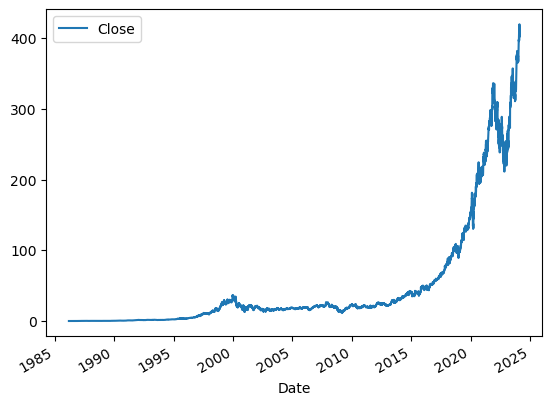

In [9]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [10]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [11]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060163,NaN
1986-03-14 00:00:00-05:00,0.062311,1.0
1986-03-17 00:00:00-05:00,0.063386,1.0
1986-03-18 00:00:00-05:00,0.061774,0.0
1986-03-19 00:00:00-05:00,0.060700,0.0


In [12]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [13]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.054792,0.062849,0.054792,0.060163,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060163,0.063386,0.060163,0.062311,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062311,0.063923,0.062311,0.063386,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.063386,0.063923,0.061237,0.061774,6.776640e+07,0.0,0.0


In [14]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [15]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062311,1.0,0.060163,1.031789e+09,0.054792,0.062849,0.054792
1986-03-17 00:00:00-05:00,0.063386,1.0,0.062311,3.081600e+08,0.060163,0.063386,0.060163
1986-03-18 00:00:00-05:00,0.061774,0.0,0.063386,1.331712e+08,0.062311,0.063923,0.062311
1986-03-19 00:00:00-05:00,0.060700,0.0,0.061774,6.776640e+07,0.063386,0.063923,0.061237
1986-03-20 00:00:00-05:00,0.059089,0.0,0.060700,4.789440e+07,0.061774,0.062311,0.060163


In [17]:
# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [19]:
data.shape

(9560, 7)

In [20]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [22]:
# Evaluate error of predictions 
preds = model.predict(test[predictors]) 
preds = pd.Series(preds, index=test.index) 
precision_score(test["Target"], preds)

0.8181818181818182

<Axes: xlabel='Date'>

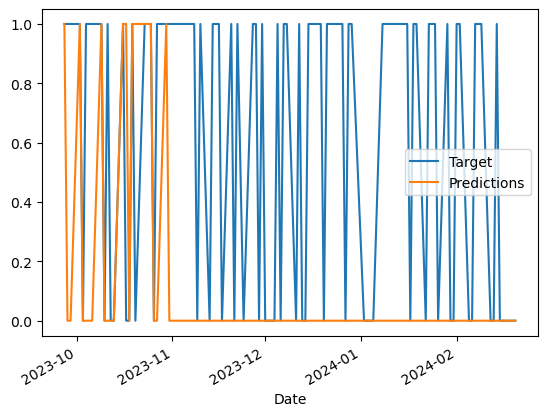

In [23]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [24]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [25]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [26]:
preds.head()

Date
1990-02-27 00:00:00-05:00    1.0
1990-02-28 00:00:00-05:00    1.0
1990-03-01 00:00:00-05:00    1.0
1990-03-02 00:00:00-05:00    1.0
1990-03-05 00:00:00-05:00    1.0
dtype: float64

In [27]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [28]:
predictions[0].head()

,Target,Predictions
Date,,
1990-02-27 00:00:00-05:00,0.0,1.0
1990-02-28 00:00:00-05:00,1.0,1.0
1990-03-01 00:00:00-05:00,1.0,1.0
1990-03-02 00:00:00-05:00,1.0,1.0
1990-03-05 00:00:00-05:00,1.0,1.0


In [29]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [30]:
predictions = backtest(data, model, predictors)

In [31]:
#Counting the number of times the model predicts the price going up or down

predictions["Predictions"].value_counts()

Predictions
0.0    7870
1.0     690
Name: count, dtype: int64

In [32]:
predictions["Target"].value_counts()

Target
1.0    4343
0.0    4217
Name: count, dtype: int64

In [33]:
# Calculate the precision of the model

precision_score(predictions["Target"], predictions["Predictions"])

0.5057971014492754

In [34]:
# Calculate some rolling means to help improve accuracy

weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [35]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [36]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [37]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [38]:
data["weekly_trend"] = weekly_trend

In [40]:
data.columns

Index(['Actual_Close', 'Target', 'Close', 'Volume', 'Open', 'High', 'Low',
       'weekly_mean', 'quarterly_mean', 'annual_mean', 'annual_weekly_mean',
       'annual_quarterly_mean', 'weekly_trend'],
      dtype='object')

In [41]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [42]:
#

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]


In [43]:
# Removing the first year's data to avoid the NaNs we've just created

predictions = backtest(data.iloc[365:], model, full_predictors)

In [44]:
# Hopefully improved precision 

precision_score(predictions["Target"], predictions["Predictions"])

0.5792880258899676

In [45]:
# Show how many trades we would make 
predictions["Predictions"].value_counts()

Predictions
0.0    7886
1.0     309
Name: count, dtype: int64

<Axes: xlabel='Date'>

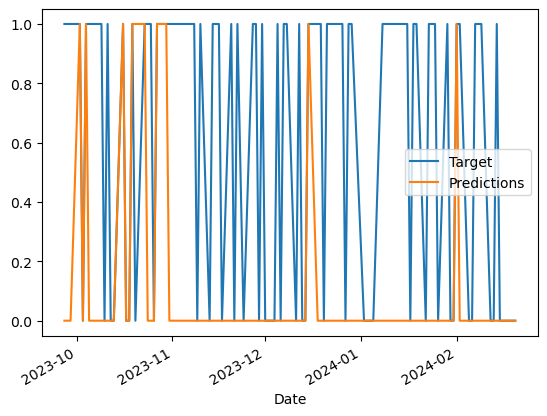

In [47]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()

In [ ]:
# An experiment from the